# MAGMA experimnetations

## Artificial data : Different HP + Common grid

In [37]:
import matplotlib.pyplot as plt
import numpy as np
import sys
import warnings

plt.style.use("bmh")
sys.path.append("../src/")
warnings.filterwarnings("ignore")

from kernels import ExponentiatedQuadraticKernel, GaussianKernel
from MAGMA import MAGMA

### Data

In [38]:
N = 100
M = 20

t0 = 10
tN = 20

common_T = np.linspace(t0, tN, N)
print(common_T.shape)

(100,)


In [39]:
a = np.random.uniform(-2, 2)
b = np.random.uniform(0, 10)

m0 = a * common_T + b
m0_function = lambda t : a * t + b
print(m0.shape)

(100,)


In [40]:
theta0 = np.array([np.random.uniform(1, np.exp(5)), np.random.uniform(1, np.exp(2))])
print(theta0)

[137.95645569   3.5056541 ]


In [41]:
K_theta0 = ExponentiatedQuadraticKernel.compute_all(theta0, common_T)
print(K_theta0.shape)

(100, 100)


In [42]:
mu0 = np.random.multivariate_normal(m0, K_theta0)
print(mu0.shape)

(100,)


In [43]:
Theta = np.array([np.random.uniform(1, np.exp(5), size=M), np.random.uniform(1, np.exp(2), size=M)]).T
Sigma = np.random.uniform(0, 1, size=M)

print(Theta)
print(Sigma)

[[113.5265175    4.3042714 ]
 [144.69966779   2.23916812]
 [126.45529512   3.90800547]
 [ 35.459656     6.82660534]
 [ 41.69702483   2.2541167 ]
 [114.54803827   6.79975232]
 [ 73.56625976   2.29787892]
 [ 28.52323746   3.64737005]
 [ 36.35931163   2.42373536]
 [146.22058305   1.05843299]
 [143.03755749   4.55597745]
 [ 80.57885856   2.74038334]
 [ 43.08763177   1.13029692]
 [142.68976398   3.39824364]
 [ 59.76982632   2.7453617 ]
 [ 53.77570647   1.37859776]
 [119.56114819   6.25162329]
 [ 44.98554244   4.56392336]
 [ 76.10480484   3.16999059]
 [ 16.76339379   5.48553452]]
[0.64670849 0.30115157 0.36977504 0.62677424 0.38285965 0.82538805
 0.23112554 0.21956623 0.67086743 0.60188736 0.84904785 0.31339784
 0.12300049 0.50640749 0.57451306 0.3195076  0.24342848 0.32218187
 0.02174471 0.85127799]


In [44]:
Y = np.zeros((M, N))
for i in range(M):
    C_Theta = ExponentiatedQuadraticKernel.compute_all(Theta[i], common_T)
    Psi_Theta_Sigma = C_Theta + Sigma[i] * np.identity(N)
    Yi = np.random.multivariate_normal(mu0, Psi_Theta_Sigma)
    Y[i] = Yi
print(Y.shape)

(20, 100)


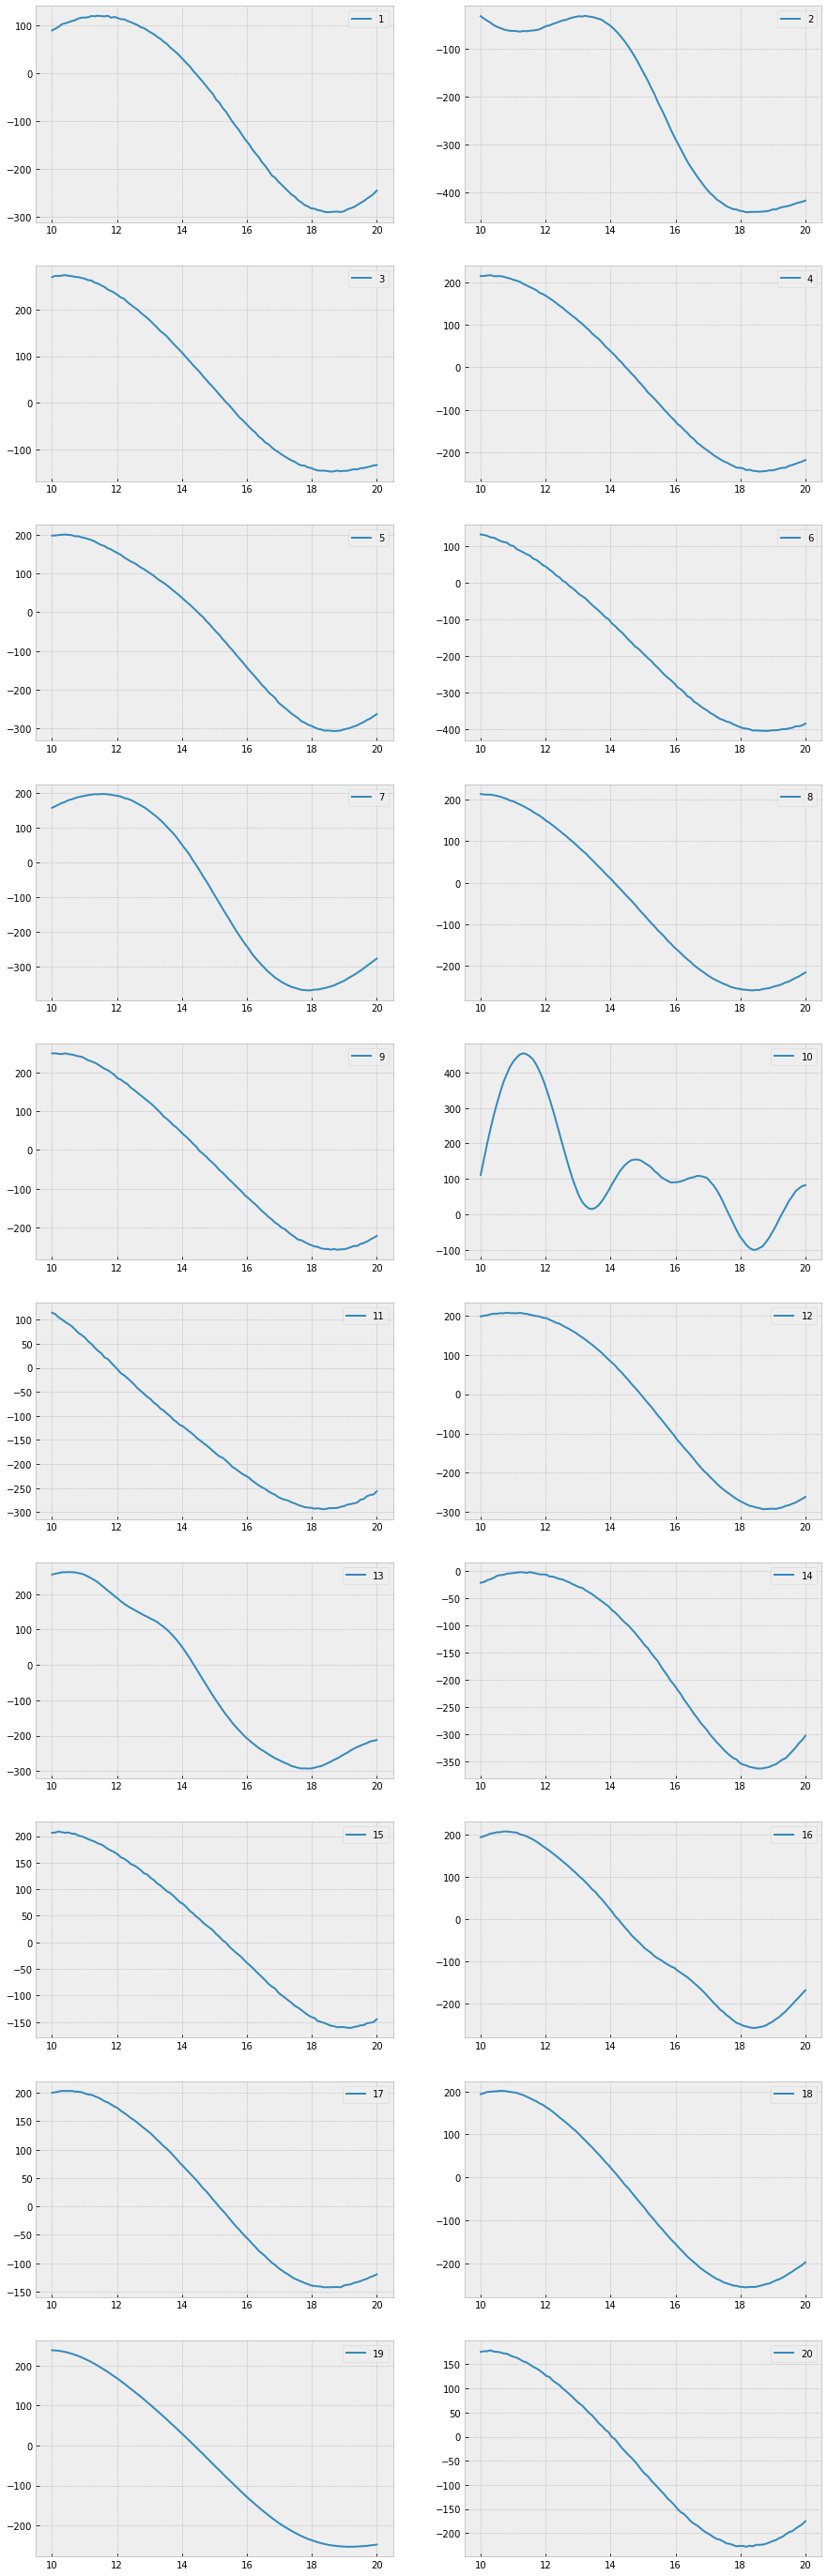

In [45]:
plt.figure(figsize=(15, int(np.ceil(M/2)) * 5))
for i in range(1, M + 1):
    plt.subplot(int(np.ceil(M/2)), 2, i)
    plt.plot(common_T, Y[i - 1], label=f"{i}")
    plt.legend()
plt.show()

### Model

#### Training

In [46]:
model = MAGMA(
    T=None,
    Y=Y,
    common_T=common_T,
    m0=np.zeros(len(m0)),
    m0_function=m0_function,
    theta0=np.array([np.random.uniform(0.99,1.01), np.random.uniform(0.99,1.01)]),
    Theta=np.array([np.random.uniform(0.99,1.01, size=M), np.random.uniform(0.99,1.01, size=M)]).T,
    Sigma=np.random.uniform(0.49, 0.51, size=M),
    common_hp_flag=False,
    common_grid_flag=True,
    save_history_flag=True,
    scipy_optimize_display=True,
    kernel_k=ExponentiatedQuadraticKernel,
    kernel_c=ExponentiatedQuadraticKernel,
)

In [47]:
model.fit(max_iterations=1, eps=1e-2)

MAGMA Training:   0%|          | 0/1 [00:00<?, ?it/s]

theta0
Theta & Sigma 0
Theta & Sigma 1
Theta & Sigma 2
Theta & Sigma 3
Theta & Sigma 4
Theta & Sigma 5
Theta & Sigma 6
Theta & Sigma 7
Theta & Sigma 8
Theta & Sigma 9
Theta & Sigma 10
Theta & Sigma 11
Theta & Sigma 12
Theta & Sigma 13
Theta & Sigma 14
Theta & Sigma 15
Theta & Sigma 16
Theta & Sigma 17
Theta & Sigma 18
Theta & Sigma 19


MAGMA Training: 100%|██████████| 1/1 [00:02<00:00,  2.85s/it]


In [48]:
model.scipy_optimize_display = False
model.fit(max_iterations=49, eps=1e-2)

MAGMA Training:  98%|█████████▊| 48/49 [00:49<00:01,  1.04s/it]


In [49]:
history = model.history
len(history)

51

In [50]:
LL_theta0 = []
LL_Theta_Sigma = []

for epoch_history in history[1:]:
    LL_theta0.append(epoch_history["LL_theta0"])
    LL_Theta_Sigma.append(epoch_history["LL_Theta_Sigma"])

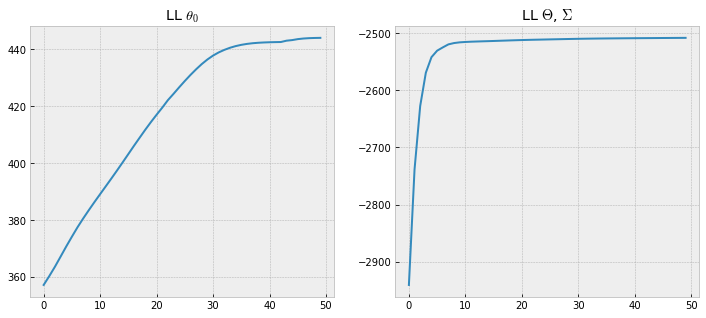

In [51]:
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(LL_theta0)
plt.title("LL $\\theta_0$")
plt.subplot(1, 2, 2)
plt.plot(LL_Theta_Sigma)
plt.title("LL $\Theta$, $\Sigma$")
plt.show()

In [52]:
Sigma_estim = []
for epoch_history in history:
    Sigma_estim.append(epoch_history["Sigma"])
Sigma_estim = np.array(Sigma_estim)
print(model.Sigma)
print(Sigma)

[ 0.81466187 -0.57784284  0.63431091  0.7131939   0.65089684  1.0606868
  0.47236294  0.45140586  0.92445285  0.71172658  0.89241823  0.55293097
  0.37832412 -0.65164142  0.74647431  0.55384615  0.4368795   0.46054861
  0.13001991  0.81148705]
[0.64670849 0.30115157 0.36977504 0.62677424 0.38285965 0.82538805
 0.23112554 0.21956623 0.67086743 0.60188736 0.84904785 0.31339784
 0.12300049 0.50640749 0.57451306 0.3195076  0.24342848 0.32218187
 0.02174471 0.85127799]


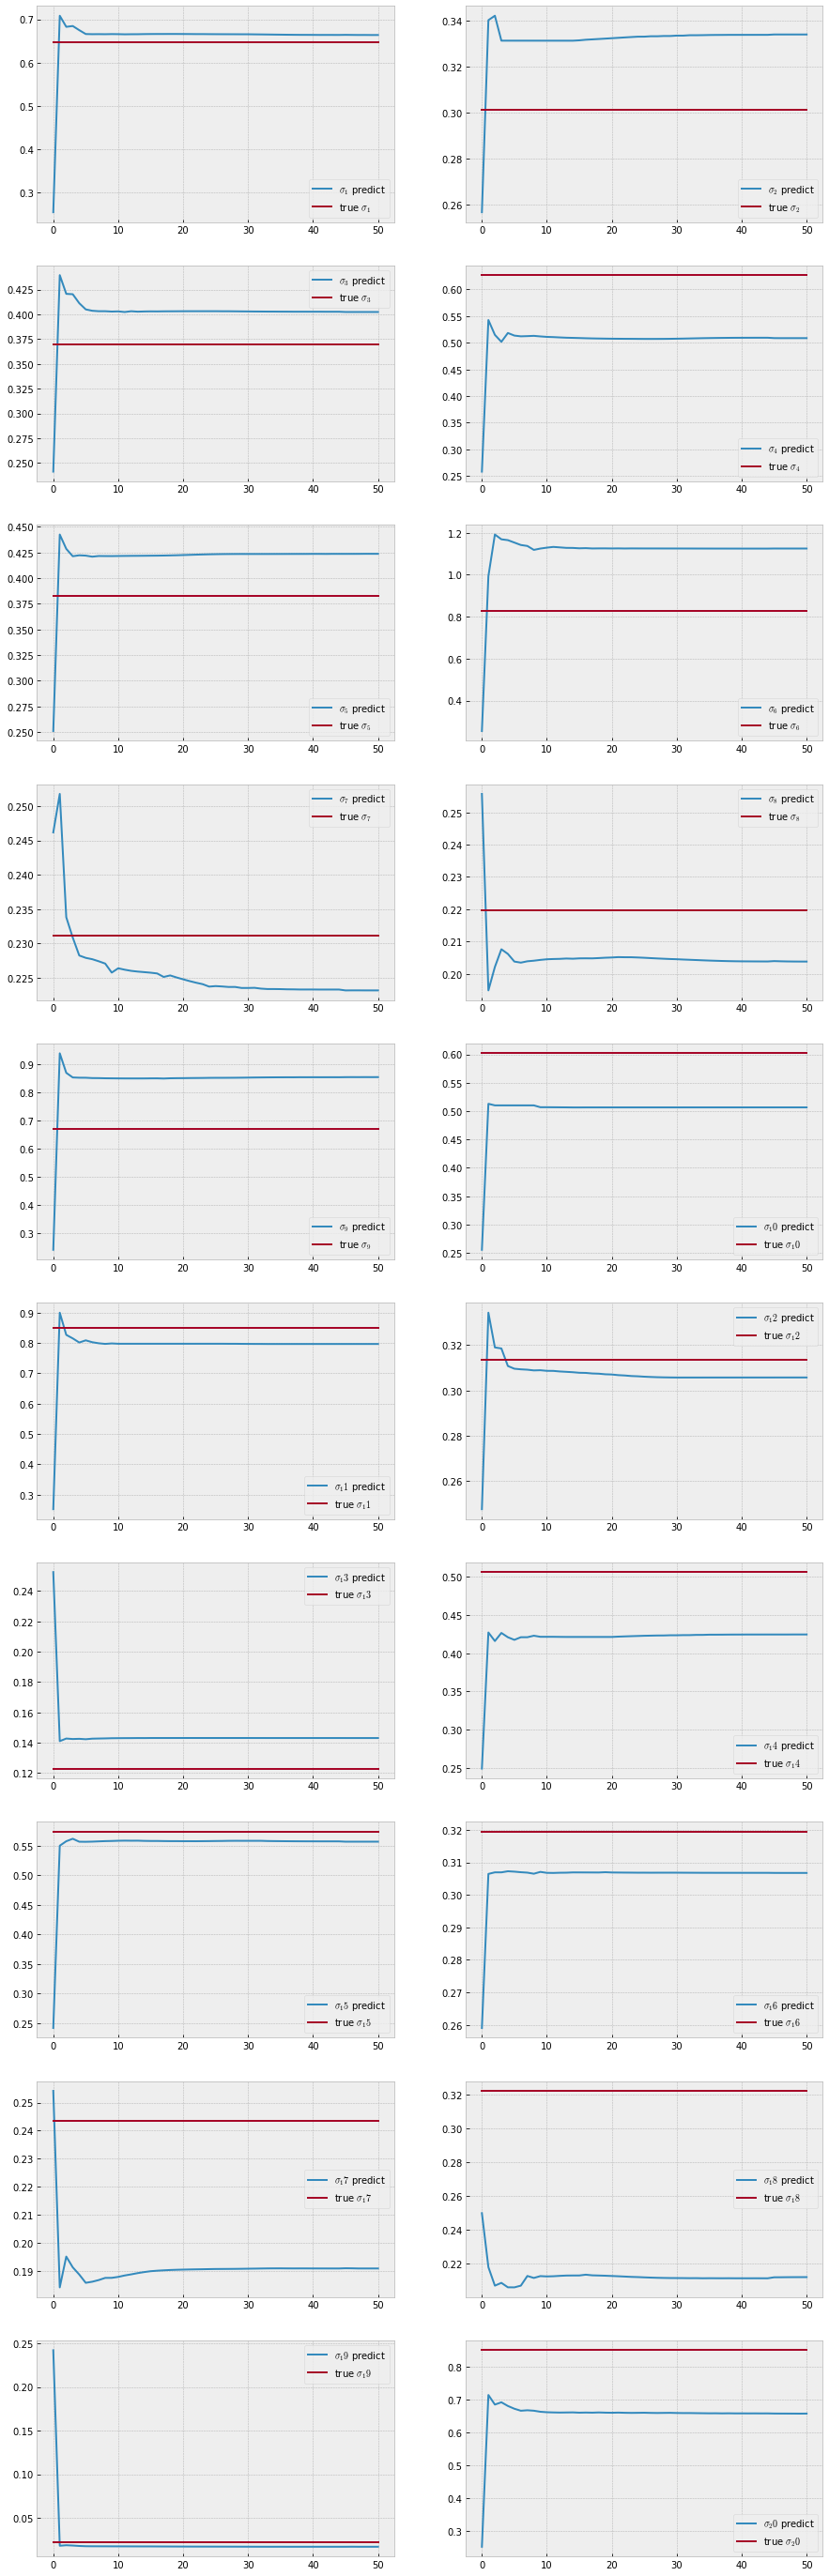

In [53]:
plt.figure(figsize=(15, int(np.ceil(M/2)) * 5))
for i in range(1, M + 1):
    plt.subplot(int(np.ceil(M/2)), 2, i)
    plt.plot(Sigma_estim[:, i - 1]**2, label=f"$\sigma_{i}$ predict")
    plt.plot(Sigma[i-1]*np.ones(len(Sigma_estim[:, i - 1])),label=f"true $\sigma_{i}$")
    plt.legend()
plt.show()

In [54]:
m0_estim_norms = []
for epoch_history in history[1:]:
    m0_estim_norms.append(np.linalg.norm(epoch_history["m0"]))

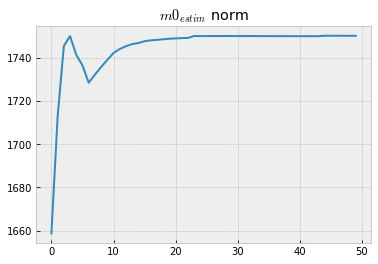

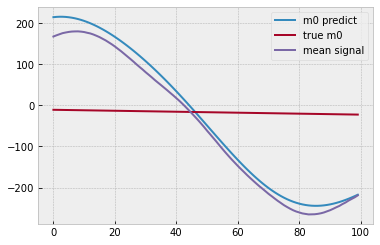

In [55]:
plt.plot(m0_estim_norms)
plt.title("$m0_{estim}$ norm")
plt.show()
plt.plot(history[-1]["m0"],label="m0 predict")
plt.plot(m0,label = "true m0")
plt.plot(Y.mean(axis=0),label = "mean signal")
plt.legend()
plt.show()

In [56]:
theta0_estim = []
for epoch_history in history:
    theta0_estim.append(epoch_history["theta0"])
theta0_estim = np.array(theta0_estim)
print(model.theta0)
print(theta0)

[175.08740217   3.70629607]
[137.95645569   3.5056541 ]


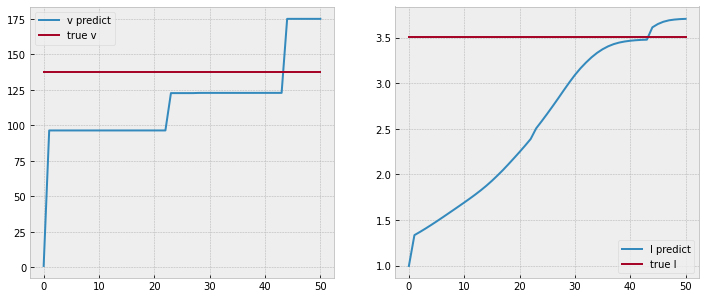

In [57]:
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(theta0_estim[:, 0], label="v predict")
plt.plot(theta0[0]*np.ones(len(theta0_estim[:, 0])), label="true v")
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(theta0_estim[:, 1], label="l predict")
plt.plot(theta0[1]*np.ones(len(theta0_estim[:, 0])), label="true l")
plt.legend()
plt.show()

In [58]:
Theta_estim = []
for epoch_history in history:
    Theta_estim.append(epoch_history["Theta"])
Theta_estim = np.array(Theta_estim)
print(Theta.shape)
print(model.Theta)
print(Theta)

(20, 2)
[[109.5771809    4.3591379 ]
 [162.49521957   2.31190493]
 [ 84.80292305   4.27858458]
 [  2.17963949   5.12524086]
 [ 28.49820361   2.0662353 ]
 [184.82518514   7.7063528 ]
 [ 72.24213086   2.23355088]
 [ 25.57488786   4.22811328]
 [ 18.72632785   2.20216599]
 [219.35646054   1.11549716]
 [129.3099808    4.54509157]
 [ 40.85170198   2.66776571]
 [ 36.45178809   1.12816648]
 [193.31910841  -3.98014264]
 [ 54.25614113   2.72581996]
 [ 32.75315038   1.35680614]
 [ 63.32270873   5.07359892]
 [ 62.43121357   4.13292121]
 [ 45.36870153   3.52235669]
 [ 51.44647527   6.779891  ]]
[[113.5265175    4.3042714 ]
 [144.69966779   2.23916812]
 [126.45529512   3.90800547]
 [ 35.459656     6.82660534]
 [ 41.69702483   2.2541167 ]
 [114.54803827   6.79975232]
 [ 73.56625976   2.29787892]
 [ 28.52323746   3.64737005]
 [ 36.35931163   2.42373536]
 [146.22058305   1.05843299]
 [143.03755749   4.55597745]
 [ 80.57885856   2.74038334]
 [ 43.08763177   1.13029692]
 [142.68976398   3.39824364]
 [ 59

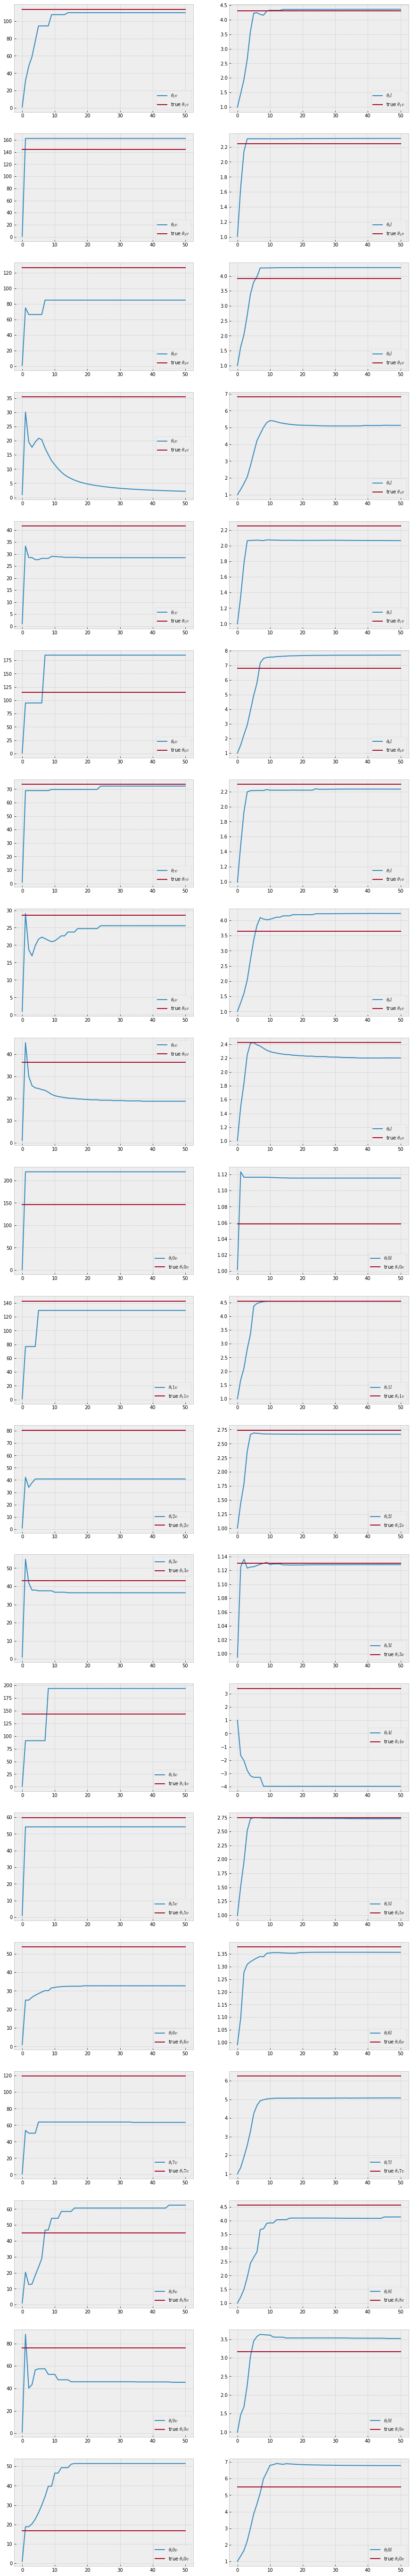

In [59]:
plt.figure(figsize=(15, M * 5))
cpt = 0
for i in range(1, M + 1):
    cpt += 1
    plt.subplot(M, 2, cpt)
    plt.plot(Theta_estim[:, i - 1, 0], label=f"$\\theta_{i} v$")
    plt.plot(Theta[i-1,0]*np.ones(len(theta0_estim[:, 0])), label=f"true $\\theta_{i} v$")
    plt.legend()
    cpt += 1
    plt.subplot(M, 2, cpt)
    plt.plot(Theta_estim[:, i - 1, 1], label=f"$\\theta_{i} l$")
    plt.plot(Theta[i-1,1]*np.ones(len(theta0_estim[:, 0])), label=f"true $\\theta_{i} v$")
    plt.legend()
plt.show()

#### Prediction

#### Type II

In [60]:
theta = np.array([np.random.uniform(1, np.exp(5)), np.random.uniform(1, np.exp(2))]).T
sigma = np.random.uniform(0, 1)
tObs = 0
T_p_obs = np.linspace(tObs, t0-1e-3, 2*N)
m_p_obs = m0_function(T_p_obs)
Cov_p_obs = ExponentiatedQuadraticKernel.compute_all(theta, T_p_obs) + sigma * np.identity(2 * N)
Y_p_obs = np.random.multivariate_normal(m_p_obs, Cov_p_obs)
T_obs = T_p_obs[:N]
T_p = T_p_obs[N:]
Y_obs = Y_p_obs[:N]
Y_p = Y_p_obs[N:]
m_P = m_p_obs[N:]

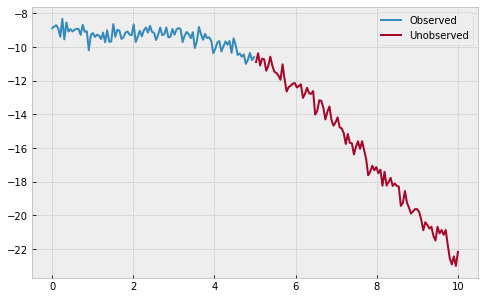

In [61]:
plt.figure(figsize=(8, 5))
plt.plot(T_obs, Y_obs, label="Observed")
plt.plot(T_p, Y_p, label="Unobserved")
plt.legend()
plt.show()

In [62]:
m_P_predict, Cov_P_predict = model.predict(T_p, T_p, Y_p)

In [63]:
((m_P_predict - m_P) ** 2).sum()/(N * M)

3.6590691726241062

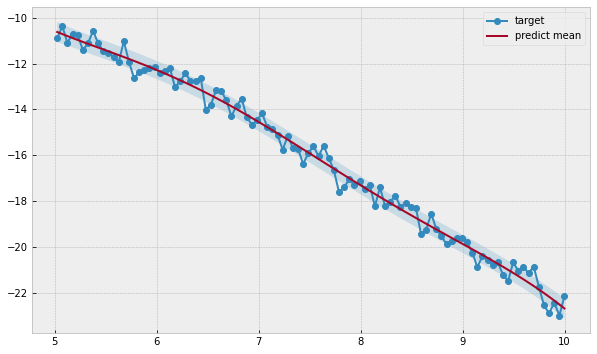

In [64]:
std_dev = np.sqrt(np.diag(Cov_P_predict))
plt.figure(figsize=(10, 6))
plt.plot(T_p, Y_p, label='target', marker='o')
plt.plot(T_p, m_P_predict, label='predict mean')
plt.fill_between(T_p, m_P_predict - std_dev, m_P_predict + std_dev, alpha=0.2)
plt.legend()
plt.show()

In [65]:
m_P_predict, Cov_P_predict = model.predict(T_p, T_obs, Y_obs)

In [66]:
((m_P_predict - m_P) ** 2).sum()/(N * M)

2.0913432918213983

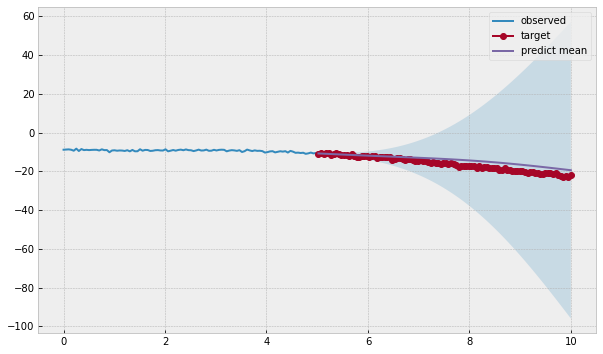

In [67]:
std_dev = np.sqrt(np.diag(Cov_P_predict))
plt.figure(figsize=(10, 6))
plt.plot(T_obs, Y_obs, label="observed")
plt.plot(T_p, Y_p, label='target', marker='o')
plt.plot(T_p, m_P_predict, label='predict mean')
plt.fill_between(T_p, m_P_predict - std_dev, m_P_predict + std_dev, alpha=0.2)
plt.legend()
plt.show()

#### Type I

In [68]:
theta = np.array([np.random.uniform(1, np.exp(5)), np.random.uniform(1, np.exp(2))]).T
sigma = np.random.uniform(0, 1)
m_p_obs = m0_function(T_p_obs)
T_p_obs = np.concatenate([common_T, np.linspace(tN+1e-3, tN + 10, N)])
Cov_p_obs = ExponentiatedQuadraticKernel.compute_all(theta, T_p_obs) + sigma * np.identity(2 * N)
Y_p_obs = np.random.multivariate_normal(m_p_obs, Cov_p_obs)
T_obs = T_p_obs[:N]
T_p = T_p_obs[N:]
Y_obs = Y_p_obs[:N]
Y_p = Y_p_obs[N:]
m_P = m_p_obs[N:]

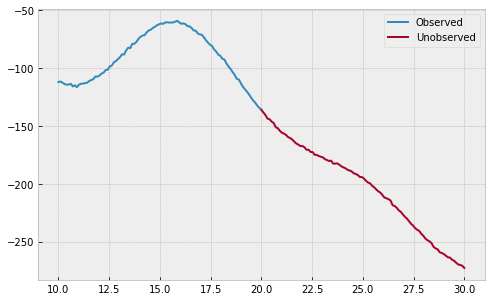

In [69]:
plt.figure(figsize=(8, 5))
plt.plot(common_T, Y_obs, label="Observed")
plt.plot(T_p, Y_p, label="Unobserved")
plt.legend()
plt.show()

In [70]:
m_P_predict, Cov_P_predict = model.predict(T_p, common_T, Y_obs)

In [71]:
((m_P_predict - m_P) ** 2).sum()/(N * M)

526.7074927120702

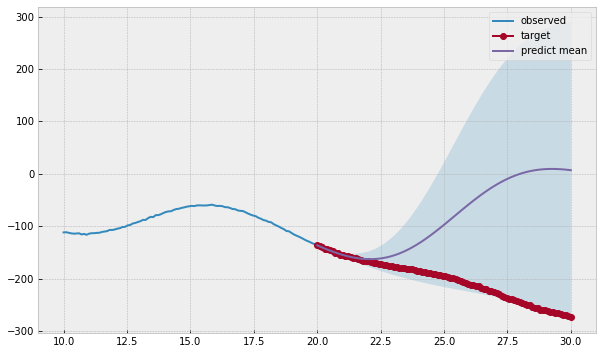

In [72]:
std_dev = np.sqrt(np.diag(Cov_P_predict))
plt.figure(figsize=(10, 6))
plt.plot(T_obs, Y_obs, label="observed")
plt.plot(T_p, Y_p, label='target', marker='o')
plt.plot(T_p, m_P_predict, label='predict mean')
plt.fill_between(T_p, m_P_predict - std_dev, m_P_predict + std_dev, alpha=0.2)
plt.legend()
plt.show()